In [1]:
import rioxarray as rx
import xarray as xr
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = ['Times New Roman + SimSun + Nowar Sans GB18030', ]  # 设置字体 simhei, Heiti TC
font_name = "Times New Roman + SimSun + Nowar Sans GB18030"

In [2]:
import os
os.chdir(r"/Volumes/2TMyRes/SynologyDrive/SCI/BeijingHeatExposure")

In [3]:
# pip install lightgbm

In [4]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
import xgboost as xgb
# print the JS visualization code to the notebook
shap.initjs()

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [6]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV, cross_validate

# data

In [7]:
random_state = 1
data = pd.read_csv(f'./气象数据/UTCI_data.csv')

In [9]:
data.columns

Index(['区站号', '经度', '纬度', '年', '月', '日', '平均风速', 'label', '日最高气温', '平均相对湿度',
       '观测场拔海高度', '日最高地表气温', 'UTCI', 'Lon', 'Lat', 'lc', 'ndvi'],
      dtype='object')

In [10]:
x_cols = [
    '观测场拔海高度',
    '日最高地表气温',
    'Lat',
    'ndvi','lc'
]
y_col = 'UTCI'

# split

In [11]:
X,y = data.loc[:,x_cols], data.loc[:,y_col]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0, test_size=0.2)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# LightGBM

In [20]:
from hyperopt import fmin, tpe, hp, Trials
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# object function
def objective(params):
    lgbm_params = {
        'learning_rate': params['learning_rate'],
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        # 'num_leaves': int(params['num_leaves']), # LightGBM 核心参数
        'verbose': -1, # 设置为 -1 以静默训练过程中的输出
        'n_jobs': -1   # 使用所有 CPU 核心
    }
    model = lgb.LGBMRegressor(**lgbm_params)
    # model = GradientBoostingRegressor(**params)
    score = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

# params
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    # 'num_leaves': hp.quniform('num_leaves', 20, 100, 1)
}

# bayes
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=300, trials=trials)


print("Best parameters found: ", best)

100%|███████| 300/300 [13:05<00:00,  2.62s/trial, best loss: 2.2208235810455386]
Best parameters found:  {'learning_rate': 0.06193737235447924, 'max_depth': 4.0, 'n_estimators': 223.0}


In [21]:
def get_best(best):
    dic  = {}
    for k, v in best.items():
        if k == 'max_depth' or k == 'n_estimators':
            v = int(v)
        else:
            v = round(v, 10)
        dic[k] = v
            
    return dic

In [22]:
bestx = get_best(best)

In [23]:
reg = lgb.LGBMRegressor(**bestx)
reg.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.0619373724, max_depth=4, n_estimators=223)

In [24]:
pred = reg.predict(X_test)
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)
rmse = root_mean_squared_error(pred, y_test)
mae = mean_absolute_error(pred, y_test)
print(r2, mse, rmse, mae)

0.8158537862446884 2.149898554242181 1.4662532367371541 1.1299446542630656


In [25]:
import seaborn as sns

In [26]:
vldata = pd.DataFrame()
vldata['pred'] = pred
vldata['y_test'] = y_test.values

In [27]:
vldata

,pred,y_test
0,38.975519,39.9
1,31.495750,30.6
2,36.114274,34.7
3,35.686235,37.5
4,35.895905,34.4
...,...,...
721,29.766469,29.4
722,28.456506,27.8
723,33.610160,32.8
724,33.943704,34.2


In [28]:
true_values = y_test.values
predicted_values = pred

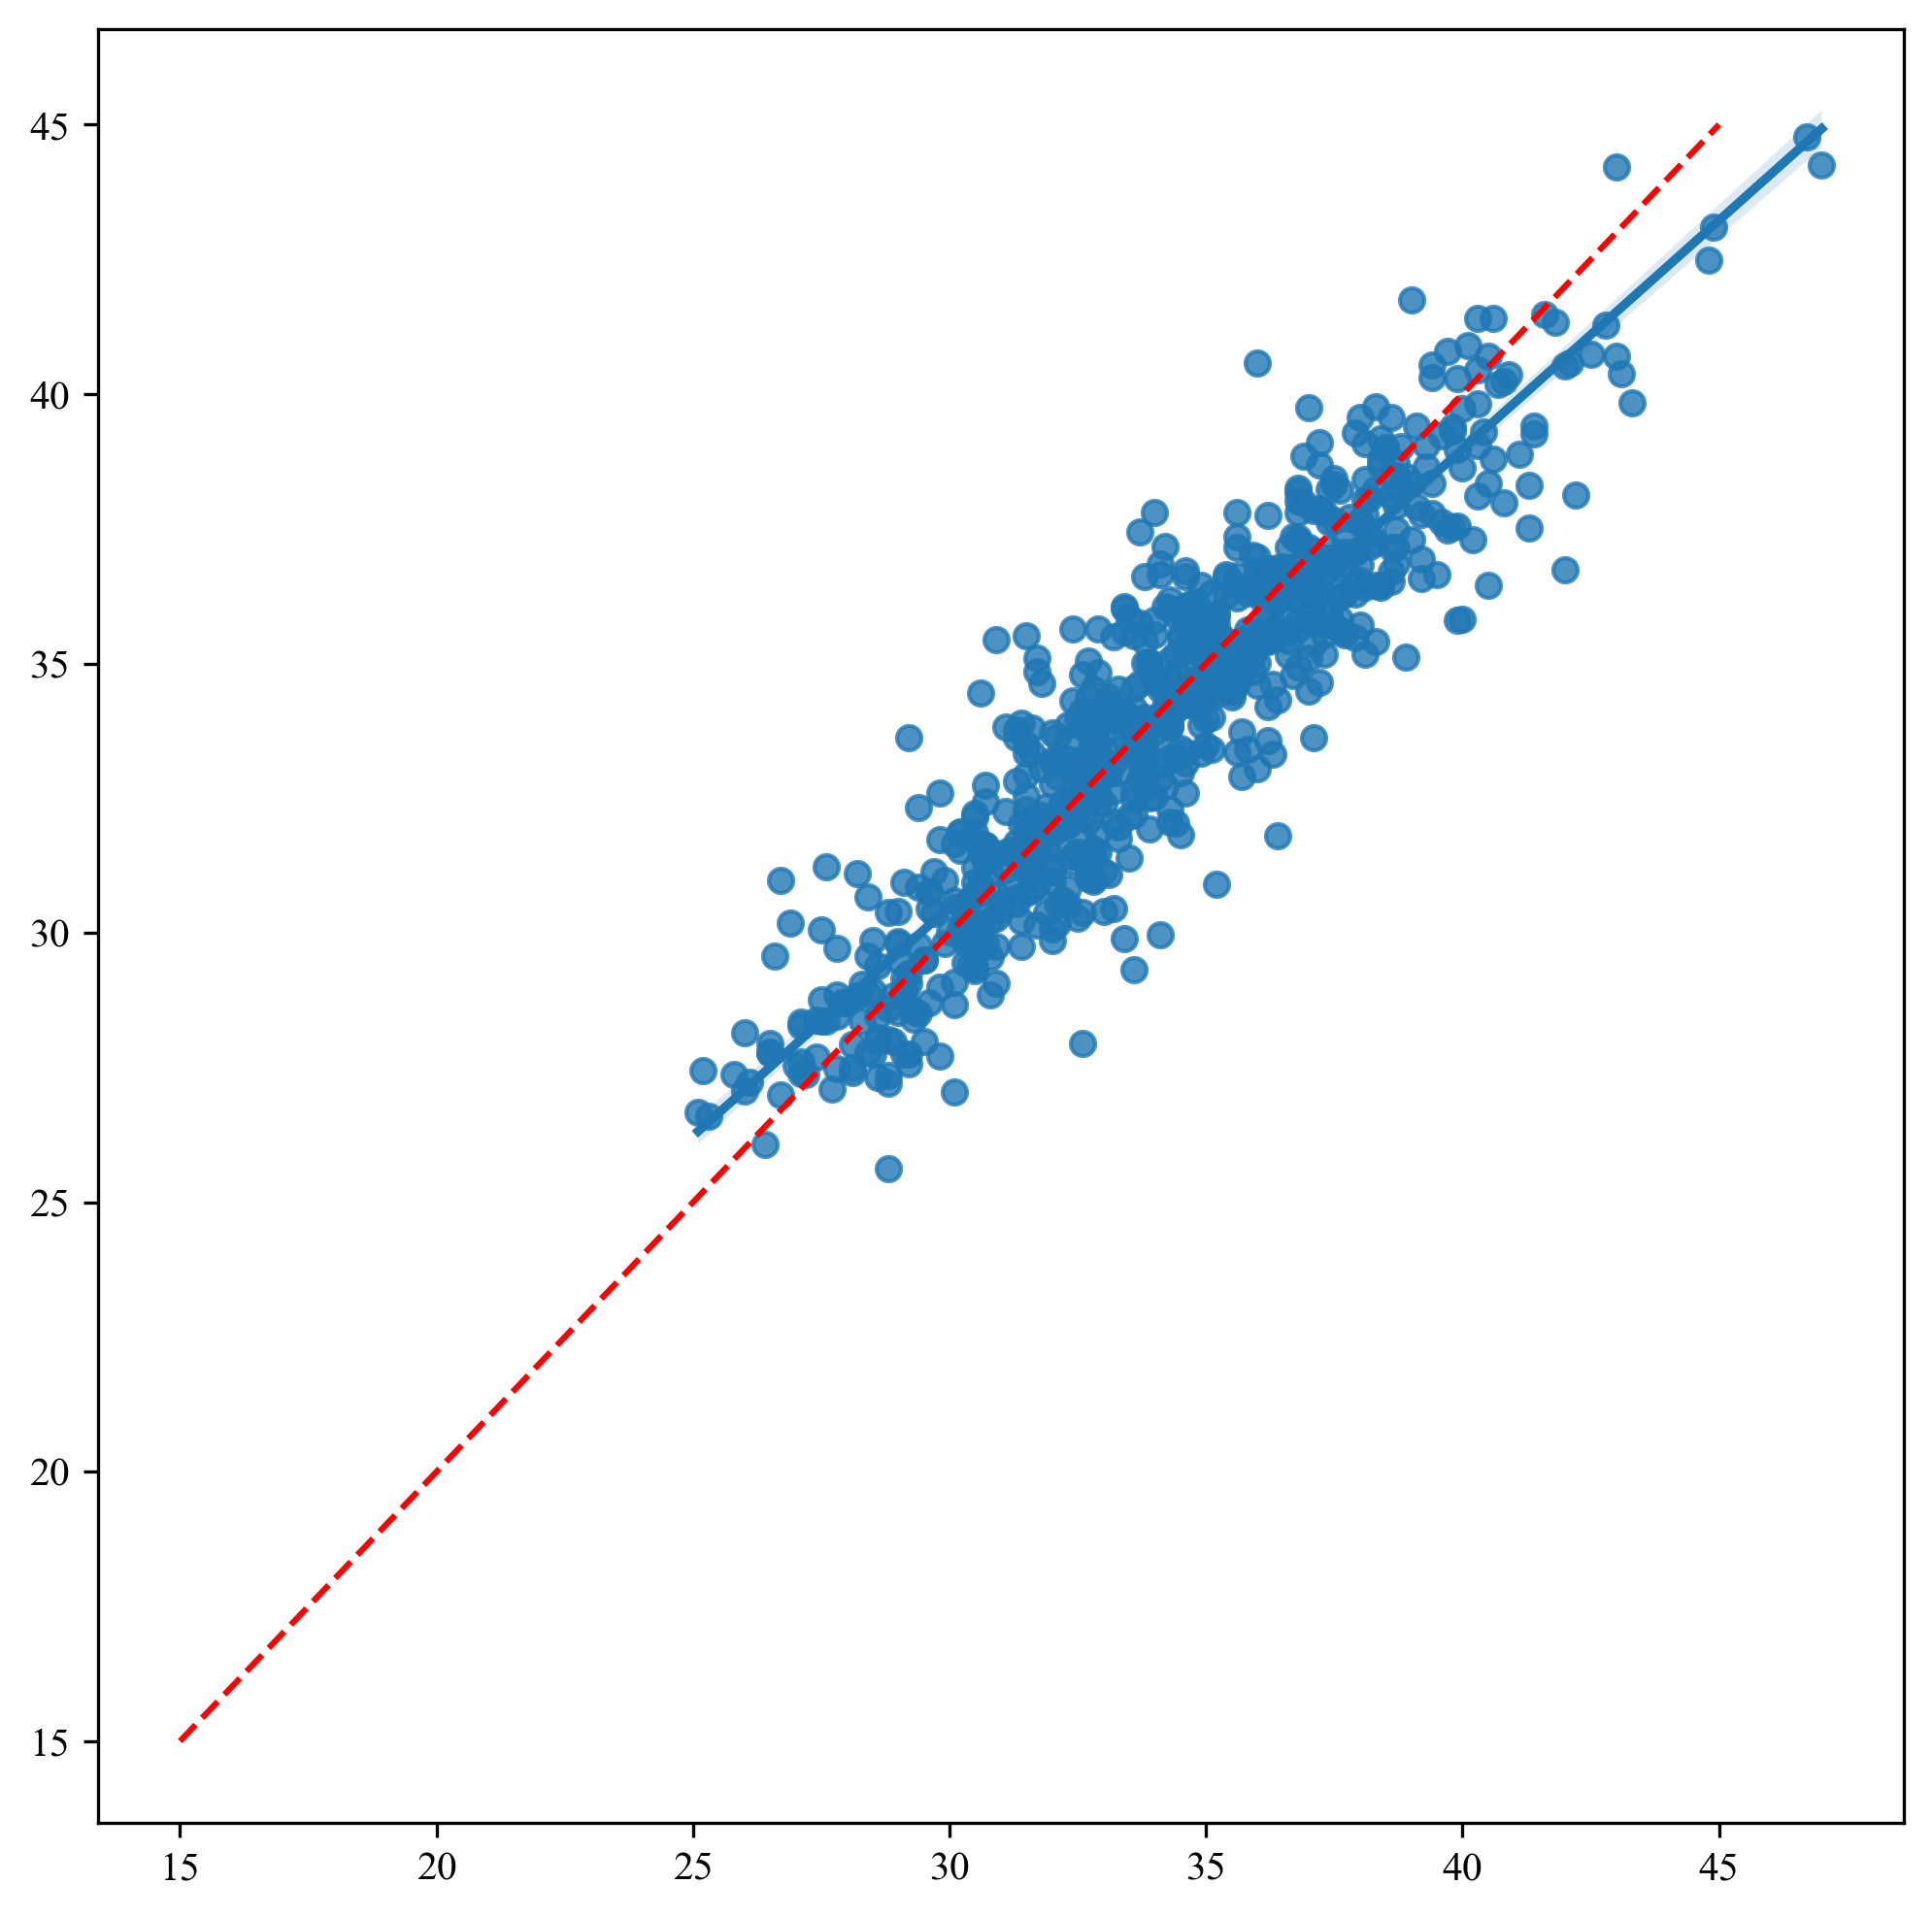

In [29]:
fig, ax = plt.subplots()
sns.regplot(x=true_values, y=predicted_values, ax=ax)
# ax.set_xlim([15,40])
# ax.set_ylim([15,40])
ax.plot([15,45], [15,45], color='r',ls='--')

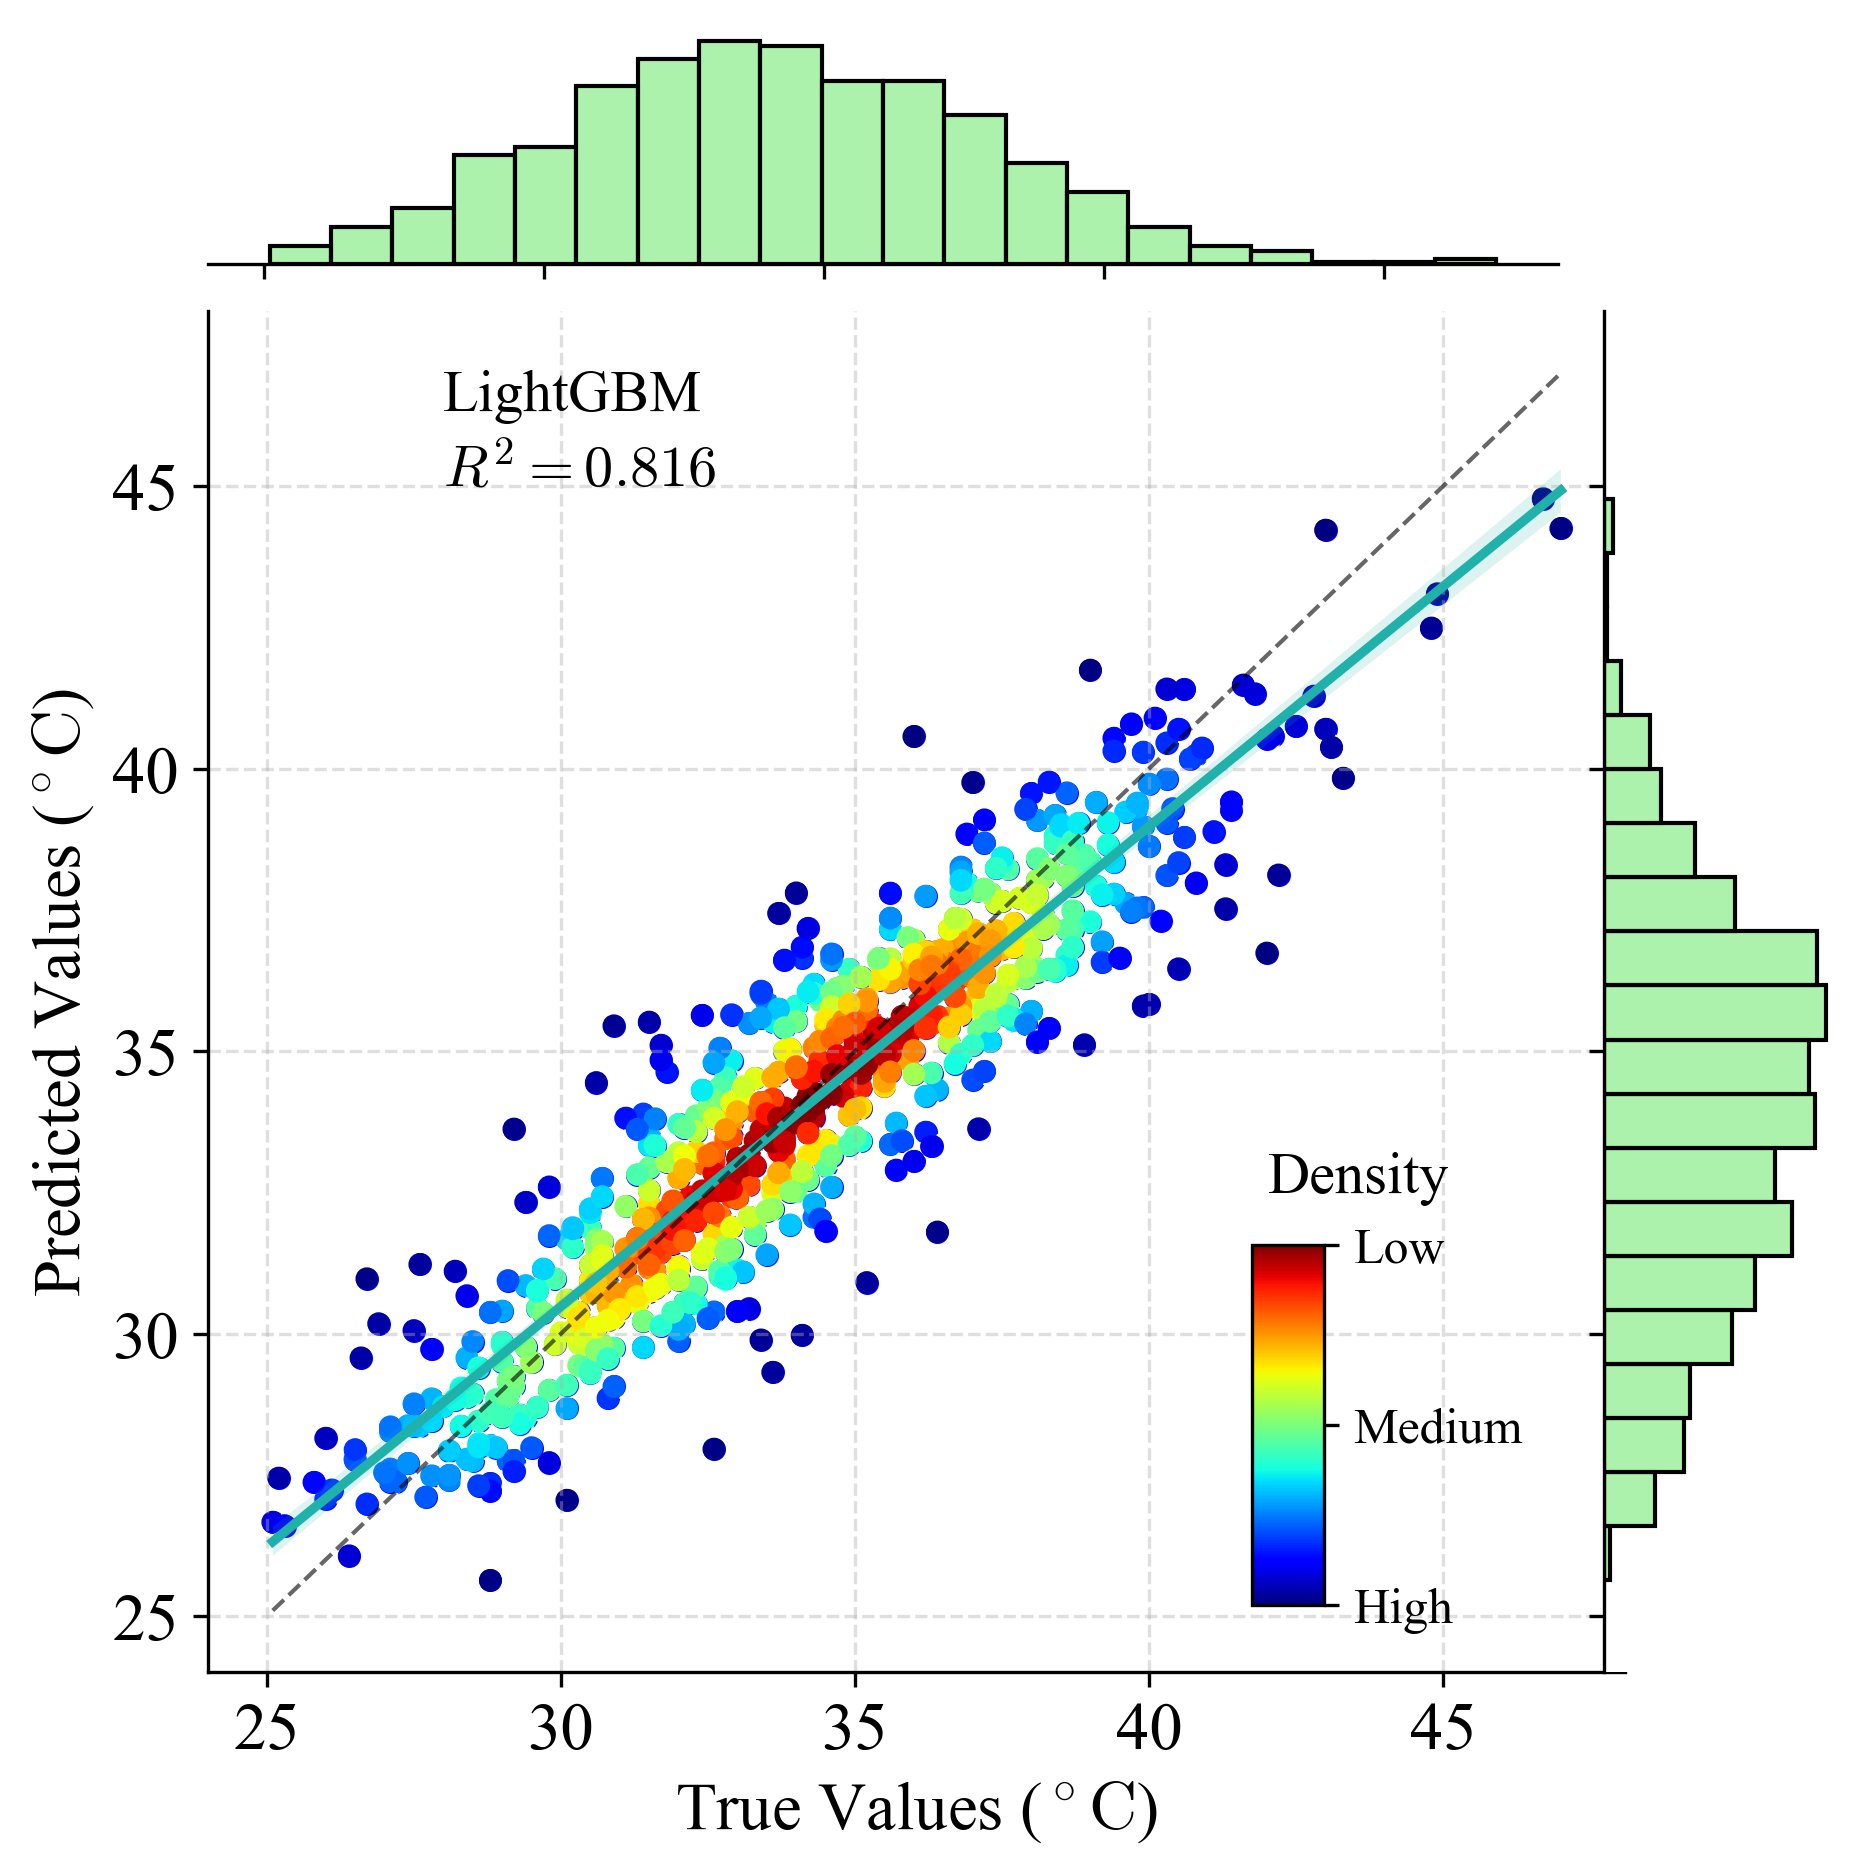

In [37]:
import seaborn as sns
from scipy.stats import gaussian_kde

# 生成模拟数据

# 计算点密度
xy = np.vstack([true_values, predicted_values])
z = gaussian_kde(xy)(xy)

# 建立画布，带边际直方图
g = sns.jointplot(
    x=true_values, y=predicted_values,
    kind="scatter", 
    marginal_kws=dict(bins=20, fill=True, color="lightgreen"),
    color="blue"
)
g.fig.set_size_inches(6, 6)  # 设置figsize
# 用散点密度着色
ax = g.ax_joint
sc = ax.scatter(true_values, predicted_values, c=z, s=20, cmap="jet")

# 添加回归线
sns.regplot(
    x=true_values, y=predicted_values, 
    scatter=False, ax=ax, line_kws={'color': 'lightseagreen'}
)

# 添加1:1参考线
lims = [min(true_values.min(), predicted_values.min()),
        max(true_values.max(), predicted_values.max())]
ax.plot(lims, lims, 'k--', alpha=0.6, lw=1)

# # 设置标签
ax.set_xlabel("True Values ($^\circ\mathrm{C}$)", fontsize=16, math_fontfamily='cm', )
ax.set_ylabel("Predicted Values ($^\circ\mathrm{C}$)", fontsize=16, math_fontfamily='cm', )
# ax.set_title("Random Forest")

# 添加颜色条（密度）
cbar = plt.colorbar(sc, ax=ax, pad=-0.2, shrink=1, aspect=5)
# cbar.set_label("Density", rotation=0, labelpad=20)

# 重新放置颜色条
cbar.ax.set_position([0.65, 0.1, 0.2, 0.2])  # [left, bottom, width, height]
ax.text(42, 32.5, 'Density', fontsize=14)

# 调整颜色条的刻度值
density_min = z.min()
density_max = z.max()
cbar.set_ticks(np.linspace(density_min, density_max, 3))  # 设置5个刻度
cbar.set_ticklabels([f"High", f"Medium", f"Low"], fontsize=12)  # 设置刻度标签


ax.tick_params(axis='both', labelsize=16)  # 设置 X 轴刻度标签的字体大小为 14 点
ax.grid(ls='--',alpha=0.4)

ax.text(28, 45, f'LightGBM\n$R^2={r2:.3f}$', fontsize=14, math_fontfamily='cm', linespacing=1.5,)

plt.savefig(f'./SavedFig/LightGBM-performance-{random_state}_1008.png', bbox_inches='tight',dpi=300)

plt.show()


In [31]:
# 你说的现象确实存在。R²高未必代表拟合就更好，可能只是因为数据取值范围大、方差高，导致残差占比显得小。

# 要不要我帮你写一段 可视化的对比代码，直接画出相同误差下不同范围的 R²效果？

In [32]:
import joblib

joblib.dump(reg, './MODEL/xgboost_with_lc_1008.joblib')

['./MODEL/xgboost_with_lc_1008.joblib']